# Neural style transfer

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2016/01/11<br>
**Last modified:** 2020/05/02<br>
**Description:** Transfering the style of a reference image to target image using gradient descent.

## Introduction

Style transfer consists in generating an image
with the same "content" as a base image, but with the
"style" of a different picture (typically artistic).
This is achieved through the optimization of a loss function
that has 3 components: "style loss", "content loss",
and "total variation loss":

- The total variation loss imposes local spatial continuity between
the pixels of the combination image, giving it visual coherence.
- The style loss is where the deep learning keeps in --that one is defined
using a deep convolutional neural network. Precisely, it consists in a sum of
L2 distances between the Gram matrices of the representations of
the base image and the style reference image, extracted from
different layers of a convnet (trained on ImageNet). The general idea
is to capture color/texture information at different spatial
scales (fairly large scales --defined by the depth of the layer considered).
- The content loss is a L2 distance between the features of the base
image (extracted from a deep layer) and the features of the combination image,
keeping the generated image close enough to the original one.

**Reference:** [A Neural Algorithm of Artistic Style](
  http://arxiv.org/abs/1508.06576)


## Setup


In [17]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

# to support usage of local modules/images, https://colab.research.google.com/notebooks/io.ipynb#scrollTo=c2W5A2px3doP
MOUNTPATH = "/content/drive"
COLABPATH = MOUNTPATH + "/My Drive/ColabNotebooks"
import sys
from google.colab import drive
drive.mount( MOUNTPATH )
sys.path.append( COLABPATH )

%load_ext autoreload
%autoreload 2
%aimport image_tools
from image_tools import get_drive_images, get_test_images, set_gen_img_dims
from image_tools import preprocess_image, deprocess_image
from image_tools import gram_matrix, style_loss, content_loss, total_variation_loss, StyleTransferLoss

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set path to image files and prepare generated image

In [18]:
# get image files from google drive
base_image_path, style_reference_image_path, result_prefix = get_drive_images(COLABPATH)

'''
# get test image files via download
base_image_path, style_reference_image_path, result_prefix = get_test_images()
'''

# Dimensions of the generated picture.
img_nrows, img_ncols = set_gen_img_dims(base_image_path=base_image_path, nrows=256)

## Check the base (content) image and the style reference image


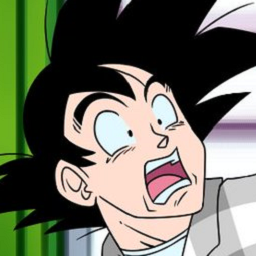

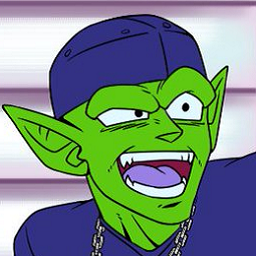

In [19]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_reference_image_path))


## Compute the content, and style-transfer loss

### First, define 4 utility functions in `image_tools` module:

- `gram_matrix` (used to compute the style loss)
- The `style_loss` function, which keeps the generated image close to the local textures
of the style reference image
- The `content_loss` function, which keeps the high-level representation of the
generated image close to that of the base image
- The `total_variation_loss` function, a regularization loss which keeps the generated
image locally-coherent



### Next, define a `StyleTransferLoss` class in the `image_tools` module:
- it prepares a VGG19 model loaded with pre-trained ImageNet weights
- it extracts the model features (such as layer names and layer outputs)
- it assigns the layers to use for content loss and style loss
- it assigns the weights for content loss and style loss
- finally, it computes the style transfer loss using the 4 utility functions defined above

In [20]:
# create an instance of the StyleTransferLoss class
GokuPiccoloLoss = StyleTransferLoss()
# setup the VGG19 model and extract features
GokuPiccoloLoss.setup_feature_extractor()

## Add a tf.function decorator to loss & gradient computation

To compile it, and thus make it fast.


In [21]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = GokuPiccoloLoss.compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

## The training loop

Repeatedly run vanilla gradient descent steps to minimize the loss, and save the
resulting image every 100 iterations.

We decay the learning rate by 0.96 every 100 steps.


In [ ]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path, nrows=img_nrows, ncols=img_ncols)
style_reference_image = preprocess_image(style_reference_image_path, nrows=img_nrows, ncols=img_ncols)
combination_image = tf.Variable(preprocess_image(base_image_path, nrows=img_nrows, ncols=img_ncols))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 2 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy(), nrows=img_nrows, ncols=img_ncols)
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)

After 12 iterations, you get the following result:


In [ ]:
display(Image(result_prefix + "_at_iteration_12.png"))

In [ ]:
# finalize and exit access to data in drive
drive.flush_and_unmount()